In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from model_file import *
from vce_dataloader import getBinaryDataLoader, getAllDataLoader, getNaryDataLoader, visualize_batch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub

In [2]:
model = getModel("resnet50")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


Order of classes:
* Normal
* Erosion
* Polyp
* Angioectasia
* Bleeding
* Lymphangiectasia
* Foreign Body
* Erythema
* Ulcer
* Worms

In [3]:
train_path = "/kaggle/input/vce-augmented-dataset/training"
val_path = "/kaggle/input/vce-augmented-dataset/validation"

In [4]:
train_transform = transforms.Compose([#transforms.RandomHorizontalFlip(p=0.7),
                                     #transforms.RandomVerticalFlip(p=0.7),
                                     #transforms.RandomRotation(15),
                                     
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor()
                              ])


val_transform= transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()])

In [5]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)  # Move images to the same device as model
            labels = labels.to(device)  # Move labels to the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    return np.array(all_preds), np.array(all_labels)

# Binary

In [6]:
target_class_names = ["Normal"]
binDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
binDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [7]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [9]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
model = model.to(device)

In [11]:
num_epochs = 2

In [12]:

for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in binDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        if(i%100 == 0):
            print(f"Bin - [{i}/{len(binDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in binDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Bin - [0/1854] train loss : 0.7442784905433655
Bin - [100/1854] train loss : 0.45407626032829285
Bin - [200/1854] train loss : 0.6311940550804138
Bin - [300/1854] train loss : 0.36550086736679077
Bin - [400/1854] train loss : 0.17340439558029175
Bin - [500/1854] train loss : 0.3157053291797638
Bin - [600/1854] train loss : 0.18418486416339874
Bin - [700/1854] train loss : 0.23835434019565582
Bin - [800/1854] train loss : 0.3243001401424408
Bin - [900/1854] train loss : 0.36736878752708435
Bin - [1000/1854] train loss : 0.29360148310661316
Bin - [1100/1854] train loss : 0.06440175324678421
Bin - [1200/1854] train loss : 0.2250434160232544
Bin - [1300/1854] train loss : 0.4603845179080963
Bin - [1400/1854] train loss : 0.39367029070854187
Bin - [1500/1854] train loss : 0.20170731842517853
Bin - [1600/1854] train loss : 0.24450275301933289
Bin - [1700/1854] train loss : 0.25843873620033264
Bin - [1800/1854] train loss : 0.2073570191860199
Epoch [1/2]
Train Loss: 0.2919, Train Accuracy: 0.

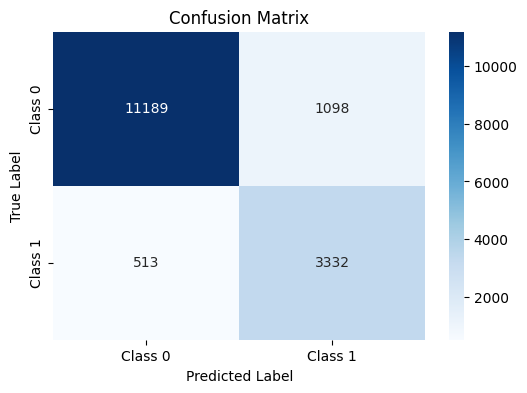

In [13]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, binDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
del binDL_train
del binDL_val

# Ternary

In [15]:
target_class_names = ["Normal","Erosion"]
terDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
terDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [16]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [18]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
model = model.to(device)

In [20]:
num_epochs = 3

In [21]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in terDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Ter - [{i}/{len(terDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in terDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Ter - [0/1854] train loss : 1.1346890926361084
Ter - [100/1854] train loss : 0.2776508331298828
Ter - [200/1854] train loss : 0.6265456676483154
Ter - [300/1854] train loss : 0.44591131806373596
Ter - [400/1854] train loss : 0.30576765537261963
Ter - [500/1854] train loss : 0.2835116684436798
Ter - [600/1854] train loss : 0.5197866559028625
Ter - [700/1854] train loss : 0.3675122857093811
Ter - [800/1854] train loss : 0.6435298919677734
Ter - [900/1854] train loss : 0.323330819606781
Ter - [1000/1854] train loss : 0.5315526127815247
Ter - [1100/1854] train loss : 0.26511627435684204
Ter - [1200/1854] train loss : 0.3080146014690399
Ter - [1300/1854] train loss : 0.4536721408367157
Ter - [1400/1854] train loss : 0.430555135011673
Ter - [1500/1854] train loss : 0.522671639919281
Ter - [1600/1854] train loss : 0.16492915153503418
Ter - [1700/1854] train loss : 0.23800906538963318
Ter - [1800/1854] train loss : 0.3758378326892853
Epoch [1/3]
Train Loss: 0.3559, Train Accuracy: 0.8532
Valid

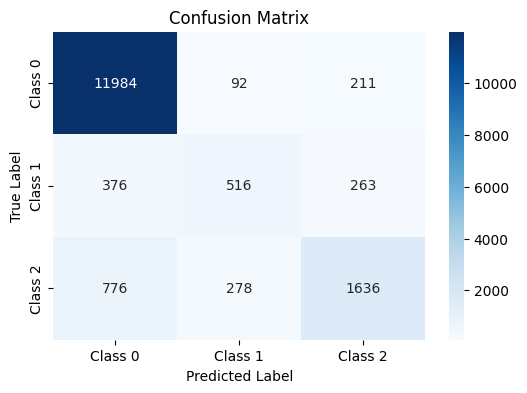

In [22]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, terDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
del terDL_train
del terDL_val

# Quaternary

In [24]:
target_class_names = ["Normal","Erosion","Polyp"]
quatDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
quatDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [25]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [27]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
model = model.to(device)

In [29]:
num_epochs = 4

In [30]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in quatDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Quat - [{i}/{len(quatDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in quatDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Quat - [0/1854] train loss : 1.157763123512268
Quat - [100/1854] train loss : 0.4221314489841461
Quat - [200/1854] train loss : 0.1942014843225479
Quat - [300/1854] train loss : 0.25435319542884827
Quat - [400/1854] train loss : 0.270487904548645
Quat - [500/1854] train loss : 0.29274648427963257
Quat - [600/1854] train loss : 0.4013693332672119
Quat - [700/1854] train loss : 0.2008822113275528
Quat - [800/1854] train loss : 0.5016006231307983
Quat - [900/1854] train loss : 0.18540428578853607
Quat - [1000/1854] train loss : 0.13509751856327057
Quat - [1100/1854] train loss : 0.47793880105018616
Quat - [1200/1854] train loss : 0.35397621989250183
Quat - [1300/1854] train loss : 0.16772814095020294
Quat - [1400/1854] train loss : 0.34458038210868835
Quat - [1500/1854] train loss : 0.33118632435798645
Quat - [1600/1854] train loss : 0.34758737683296204
Quat - [1700/1854] train loss : 0.7297539114952087
Quat - [1800/1854] train loss : 0.3678463101387024
Epoch [1/4]
Train Loss: 0.3393, Tra

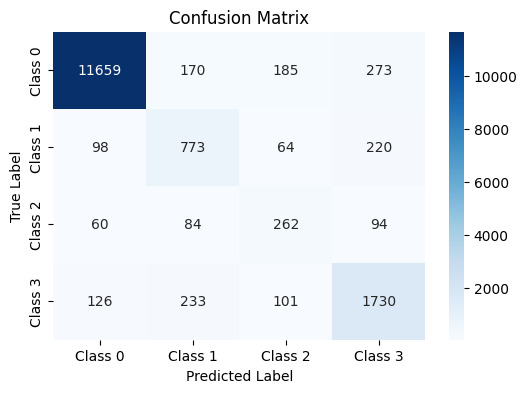

In [31]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, quatDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [32]:
del quatDL_train
del quatDL_val

# Pentanary

In [33]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia"]
pentDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
pentDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [34]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [36]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
model = model.to(device)

In [38]:
num_epochs = 5

In [39]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in pentDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Pent - [{i}/{len(pentDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in pentDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Pent - [0/1854] train loss : 1.5683170557022095
Pent - [100/1854] train loss : 0.2664135694503784
Pent - [200/1854] train loss : 0.2469060868024826
Pent - [300/1854] train loss : 0.27689746022224426
Pent - [400/1854] train loss : 0.12361003458499908
Pent - [500/1854] train loss : 0.201502725481987
Pent - [600/1854] train loss : 0.3930719792842865
Pent - [700/1854] train loss : 0.31882444024086
Pent - [800/1854] train loss : 0.3896319568157196
Pent - [900/1854] train loss : 0.41537022590637207
Pent - [1000/1854] train loss : 0.05610436946153641
Pent - [1100/1854] train loss : 0.2685435712337494
Pent - [1200/1854] train loss : 0.3111408054828644
Pent - [1300/1854] train loss : 0.10438234359025955
Pent - [1400/1854] train loss : 0.41128769516944885
Pent - [1500/1854] train loss : 0.12991318106651306
Pent - [1600/1854] train loss : 0.3124922215938568
Pent - [1700/1854] train loss : 0.26954764127731323
Pent - [1800/1854] train loss : 0.2723226547241211
Epoch [1/5]
Train Loss: 0.2889, Train 

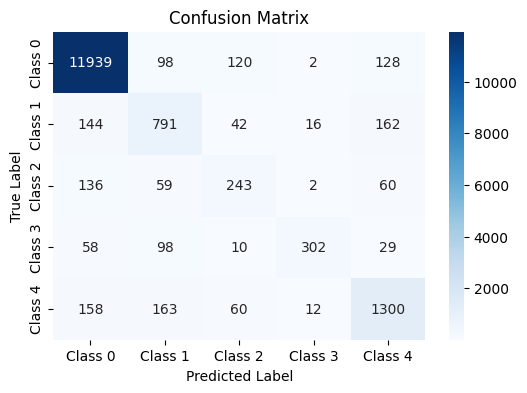

In [40]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, pentDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [41]:
del pentDL_train
del pentDL_val

# Senary

In [42]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding"]
senDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
senDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [43]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [45]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
model = model.to(device)

In [47]:
num_epochs = 6

In [48]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in senDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"[Sen - {i}/{len(senDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in senDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

[Sen - 0/1854] train loss : 1.7107648849487305
[Sen - 100/1854] train loss : 0.18960824608802795
[Sen - 200/1854] train loss : 0.3883121907711029
[Sen - 300/1854] train loss : 0.17957402765750885
[Sen - 400/1854] train loss : 0.3368385136127472
[Sen - 500/1854] train loss : 0.284449964761734
[Sen - 600/1854] train loss : 0.4748823642730713
[Sen - 700/1854] train loss : 0.34262990951538086
[Sen - 800/1854] train loss : 0.21161404252052307
[Sen - 900/1854] train loss : 0.14438119530677795
[Sen - 1000/1854] train loss : 0.11637528985738754
[Sen - 1100/1854] train loss : 0.13943535089492798
[Sen - 1200/1854] train loss : 0.20657753944396973
[Sen - 1300/1854] train loss : 0.4680265784263611
[Sen - 1400/1854] train loss : 0.09052379429340363
[Sen - 1500/1854] train loss : 0.11184889078140259
[Sen - 1600/1854] train loss : 0.15522277355194092
[Sen - 1700/1854] train loss : 0.06220632418990135
[Sen - 1800/1854] train loss : 0.42363154888153076
Epoch [1/6]
Train Loss: 0.2401, Train Accuracy: 0.

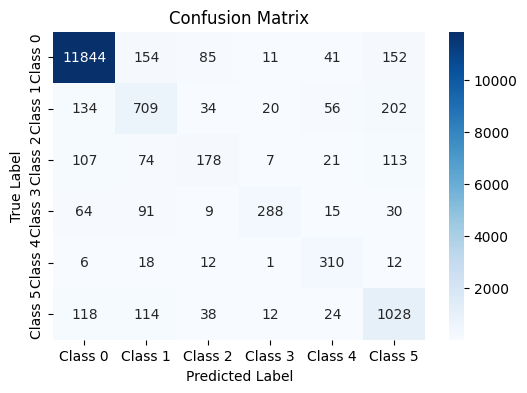

In [49]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, senDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [50]:
del senDL_train
del senDL_val

# Septenary

In [51]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia"]
septDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
septDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [52]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [54]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [55]:
model = model.to(device)

In [56]:
num_epochs = 7

In [57]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in septDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Sept - [{i}/{len(septDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in septDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Sept - [0/1854] train loss : 2.4298768043518066
Sept - [100/1854] train loss : 0.3817530870437622
Sept - [200/1854] train loss : 0.1942717730998993
Sept - [300/1854] train loss : 0.1948413997888565
Sept - [400/1854] train loss : 0.3403310775756836
Sept - [500/1854] train loss : 0.037268269807100296
Sept - [600/1854] train loss : 0.05128294229507446
Sept - [700/1854] train loss : 0.14805975556373596
Sept - [800/1854] train loss : 0.14633958041667938
Sept - [900/1854] train loss : 0.20045027136802673
Sept - [1000/1854] train loss : 0.1337042897939682
Sept - [1100/1854] train loss : 0.2351984679698944
Sept - [1200/1854] train loss : 0.13921396434307098
Sept - [1300/1854] train loss : 0.23230203986167908
Sept - [1400/1854] train loss : 0.11244550347328186
Sept - [1500/1854] train loss : 0.2514991760253906
Sept - [1600/1854] train loss : 0.0867079421877861
Sept - [1700/1854] train loss : 0.28910031914711
Sept - [1800/1854] train loss : 0.19869394600391388
Epoch [1/7]
Train Loss: 0.1782, Tra

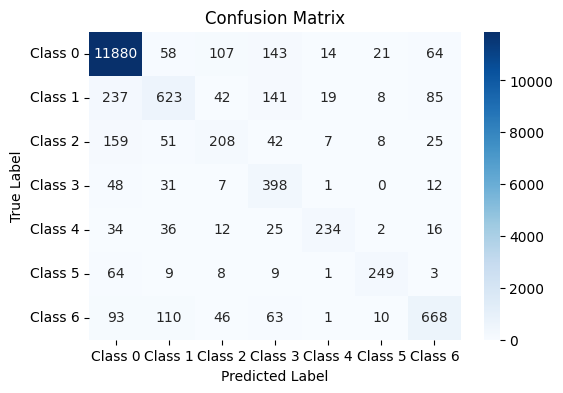

In [58]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, septDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [59]:
del septDL_train
del septDL_val

# Octal

In [60]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body"]
octDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
octDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [61]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [63]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [64]:
model = model.to(device)

In [65]:
num_epochs = 8

In [66]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in octDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Oct - [{i}/{len(octDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in octDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Oct - [0/1854] train loss : 2.754426956176758
Oct - [100/1854] train loss : 0.16784654557704926
Oct - [200/1854] train loss : 0.16382494568824768
Oct - [300/1854] train loss : 0.13067369163036346
Oct - [400/1854] train loss : 0.1857515424489975
Oct - [500/1854] train loss : 0.07824495434761047
Oct - [600/1854] train loss : 0.016179794445633888
Oct - [700/1854] train loss : 0.056800711899995804
Oct - [800/1854] train loss : 0.06823843717575073
Oct - [900/1854] train loss : 0.02594716101884842
Oct - [1000/1854] train loss : 0.21404248476028442
Oct - [1100/1854] train loss : 0.11891694366931915
Oct - [1200/1854] train loss : 0.12317006289958954
Oct - [1300/1854] train loss : 0.1432359516620636
Oct - [1400/1854] train loss : 0.20050589740276337
Oct - [1500/1854] train loss : 0.18517887592315674
Oct - [1600/1854] train loss : 0.0817171111702919
Oct - [1700/1854] train loss : 0.08273065090179443
Oct - [1800/1854] train loss : 0.19906866550445557
Epoch [1/8]
Train Loss: 0.1406, Train Accuracy

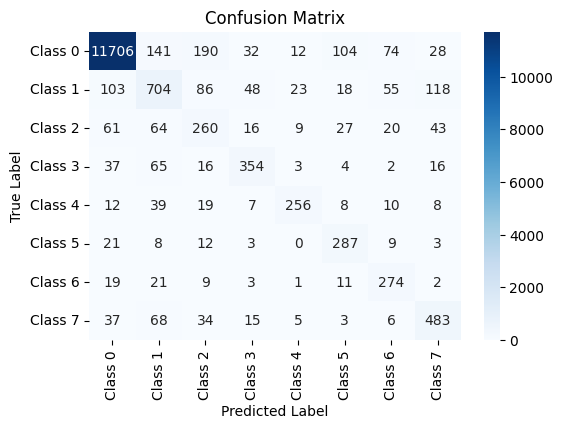

In [67]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, octDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [68]:
del octDL_train
del octDL_val

# Nonary

In [69]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body", "Erythema"]
nonDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
nonDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [70]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [72]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [73]:
model = model.to(device)

In [74]:
num_epochs = 9

In [75]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in nonDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Non - [{i}/{len(nonDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in nonDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Non - [0/1854] train loss : 2.4541375637054443
Non - [100/1854] train loss : 0.14387881755828857
Non - [200/1854] train loss : 0.08661077916622162
Non - [300/1854] train loss : 0.04641040787100792
Non - [400/1854] train loss : 0.03978444263339043
Non - [500/1854] train loss : 0.018167290836572647
Non - [600/1854] train loss : 0.019266244024038315
Non - [700/1854] train loss : 0.012971888296306133
Non - [800/1854] train loss : 0.011544491164386272
Non - [900/1854] train loss : 0.03736935183405876
Non - [1000/1854] train loss : 0.023540152236819267
Non - [1100/1854] train loss : 0.030912945047020912
Non - [1200/1854] train loss : 0.18474522233009338
Non - [1300/1854] train loss : 0.08538675308227539
Non - [1400/1854] train loss : 0.03594820201396942
Non - [1500/1854] train loss : 0.031482014805078506
Non - [1600/1854] train loss : 0.025629058480262756
Non - [1700/1854] train loss : 0.016026517376303673
Non - [1800/1854] train loss : 0.011098336428403854
Epoch [1/9]
Train Loss: 0.0850, Tr

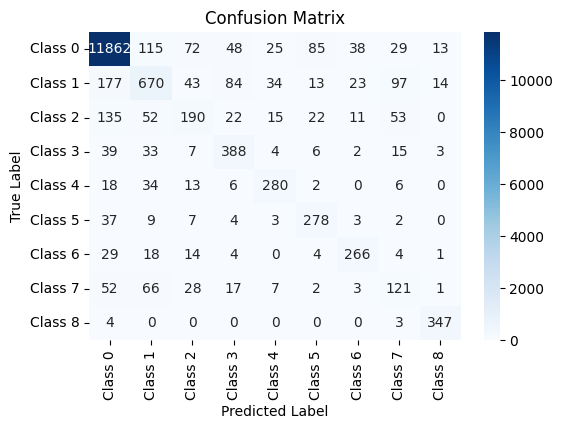

In [76]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, nonDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [77]:
del nonDL_train
del nonDL_val

# Decimal

In [78]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body", "Erythema","Ulcer"]
decDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
decDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [79]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [81]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [82]:
model = model.to(device)

In [83]:
num_epochs = 10

In [84]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in decDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Dec - [{i}/{len(decDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in decDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Dec - [0/1854] train loss : 3.0356383323669434
Dec - [100/1854] train loss : 0.023278743028640747
Dec - [200/1854] train loss : 0.026421798393130302
Dec - [300/1854] train loss : 0.03318994864821434
Dec - [400/1854] train loss : 0.01287057250738144
Dec - [500/1854] train loss : 0.054596398025751114
Dec - [600/1854] train loss : 0.061790429055690765
Dec - [700/1854] train loss : 0.10836578905582428
Dec - [800/1854] train loss : 0.02254890277981758
Dec - [900/1854] train loss : 0.09623705595731735
Dec - [1000/1854] train loss : 0.009704581461846828
Dec - [1100/1854] train loss : 0.035462427884340286
Dec - [1200/1854] train loss : 0.016286121681332588
Dec - [1300/1854] train loss : 0.014530316926538944
Dec - [1400/1854] train loss : 0.14056864380836487
Dec - [1500/1854] train loss : 0.07056856155395508
Dec - [1600/1854] train loss : 0.006393339019268751
Dec - [1700/1854] train loss : 0.10676224529743195
Dec - [1800/1854] train loss : 0.06095554679632187
Epoch [1/10]
Train Loss: 0.0667, Tr

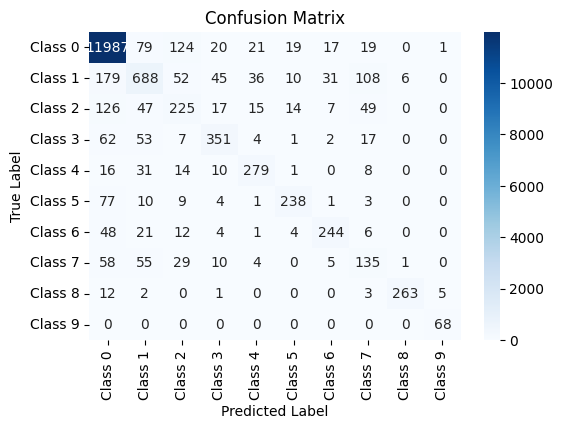

In [85]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, decDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [86]:
del decDL_train
del decDL_val

# Final

In [87]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body", "Erythema","Ulcer","Worms"]
finDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
finDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [88]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [90]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [91]:
model = model.to(device)

In [92]:
num_epochs = 15

In [93]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in finDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Fin - [{i}/{len(finDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in finDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Fin - [0/1854] train loss : 2.561659336090088
Fin - [100/1854] train loss : 0.017850114032626152
Fin - [200/1854] train loss : 0.20747679471969604
Fin - [300/1854] train loss : 0.01989162713289261
Fin - [400/1854] train loss : 0.04229443892836571
Fin - [500/1854] train loss : 0.010308237746357918
Fin - [600/1854] train loss : 0.0324757844209671
Fin - [700/1854] train loss : 0.010811670683324337
Fin - [800/1854] train loss : 0.1255648136138916
Fin - [900/1854] train loss : 0.04967237636446953
Fin - [1000/1854] train loss : 0.020374463871121407
Fin - [1100/1854] train loss : 0.006577012129127979
Fin - [1200/1854] train loss : 0.06400378048419952
Fin - [1300/1854] train loss : 0.07888854295015335
Fin - [1400/1854] train loss : 0.026697663590312004
Fin - [1500/1854] train loss : 0.0077171833254396915
Fin - [1600/1854] train loss : 0.006244988180696964
Fin - [1700/1854] train loss : 0.0022827060893177986
Fin - [1800/1854] train loss : 0.13463741540908813
Epoch [1/15]
Train Loss: 0.0478, Tra

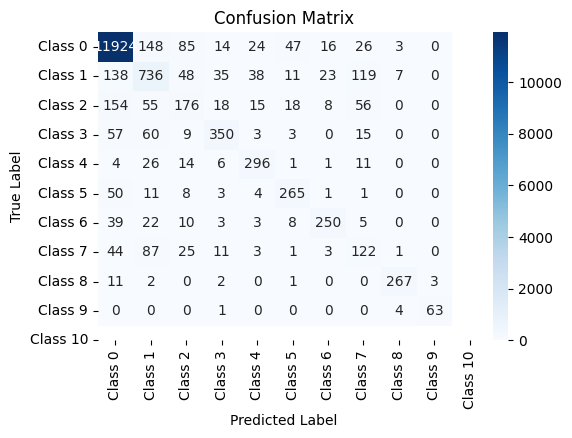

In [94]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, finDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [95]:
del finDL_train
del finDL_val

In [96]:
final_path = "checkpoint.pth"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, final_path)